Cats vs dogs
============

[Insert problem statement, provide background]

Simple CNN model to discriminate between cats and dogs

In [2]:
from keras.applications.resnet50 import ResNet50

res = ResNet50(include_top=True, weights='imagenet')

102858752/102853048 [==============================] - 8s 0us/step


In [1]:
!unzip -qo ../../data/lab2/train.zip 
!unzip -qo ../../data/lab2/test1.zip 
!cp -rf train/ ../../data/lab2/train/
!rm -r train/
!cp -rf test1/ ../../data/lab2/test1/
!rm -r test1/

### Explore the dataset


In [2]:
import os
import random
import imageio

train_dir = '../../data/lab2/train'
validation_dir = "../../data/lab2/validation"
test_dir  = '../../data/lab2/test1'

samples = random.sample(os.listdir(train_dir), 10)
sample_images = [imageio.imread(os.path.join(train_dir, f)) for f in samples]

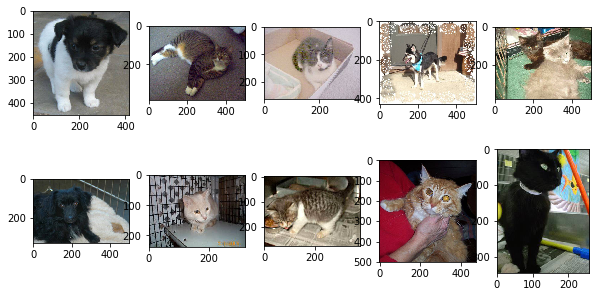

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

figure = plt.figure(figsize=(10,5))
for i, sample in enumerate(sample_images):
    ax = figure.add_subplot(2, 5, i+1)
    ax.imshow(sample)

### Split data set into training and validation

Insert text here, make it verbose

In [4]:
import os
import glob
import shutil
from sklearn.model_selection import train_test_split

training_files = glob.glob(os.path.join(train_dir, "*.jpg"))
train, validation = train_test_split(training_files, train_size=0.75, test_size=0.25)
os.makedirs(validation_dir, exist_ok=True)

# move all the validation data
for f in validation:
    shutil.move(f, validation_dir)    

## Directory cleanup

Prepping data for keras, skip section in presentation

In [5]:
def create_category_directories(dirname: str) -> None:
    """
    Creates category directories for cats and dogs in the parent directory
    """
    cats_dir = os.path.join(dirname, "cat")
    dogs_dir = os.path.join(dirname, "dog")
    
    os.makedirs(cats_dir, exist_ok=True)
    os.makedirs(dogs_dir, exist_ok=True)
    
    dog_images = glob.glob(os.path.join(dirname, "dog*.jpg"))
    cat_images = glob.glob(os.path.join(dirname, "cat*.jpg"))
    
    for d in dog_images:
        shutil.move(d, dogs_dir)
    for c in cat_images:
        shutil.move(c, cats_dir)

# create category directories for training and validation data
create_category_directories(train_dir)
create_category_directories(validation_dir)

Error: Destination path '../../data/lab2/train/dog/dog.1.jpg' already exists

### Simple conv net architecture

Let's reuse the conv net we used for digit recognition

In [ ]:
# input - 28 x 28
# https://medium.com/@siddharthdas_32104/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5
from keras.layers import Conv2D, MaxPool2D, Input, Dense, Flatten
from keras.models import Model, Sequential

def build_lenet():
    """
    Function returns a model that is ready for training
    """
    input_shape = (28, 28, 1)
    
    lenet = Sequential()
    lenet.add(Conv2D(filters=32,
                      name="conv_1",
                      kernel_size=(3,3),
                      activation="relu",
                      padding='valid',
                      input_shape=input_shape))

    lenet.add(Conv2D(filters=12,
                      kernel_size=(5,5),
                      padding='valid',
                      name="conv_2",
                      activation="relu"))

    lenet.add(Flatten())
    lenet.add(Dense(units=1,
                      name='output',
                      activation='sigmoid'))
    return lenet

In [ ]:
lenet = build_lenet()
lenet.summary()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# configure generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

# setup generators for data
train_generator = train_datagen.flow_from_directory(
                     train_dir,
                     target_size=(28, 28),
                     batch_size=32,
                     class_mode='binary',
                     color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
                     validation_dir,
                     target_size=(28, 28),
                     batch_size=32,
                     class_mode='binary',
                     color_mode='grayscale')

In [ ]:
from keras import backend as K
K.set_learning_phase(True)  # important if you have modules like dropout in your model
lenet.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from lib.default_utils import default_callbacks

logpath, dfcb = default_callbacks(lenet, prefix='dogs_v_cats_lenet', batch_size=32)

# write model graph
model_json = lenet.to_json()
with open(os.path.join(logpath, "model_graph.json"), "w") as f:
    f.write(model_json)

# start training
lenet.fit_generator(
        train_generator,
        steps_per_epoch=15000,
        epochs=10,
        callbacks = dfcb,
        validation_data=validation_generator,
        validation_steps=2000)

# save final weights after completion of training
lenet.save_weights(os.path.join(logpath, "model_weights.h5"))

*Note to self*:
This is why you need GPUs to train your model

### Transfer learning
Use a network trained for generic object classification. Fine tune it for your applications

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
model = VGG16(include_top=False, 
              weights='imagenet', 
              input_shape=(224,224,3))

# freeze weights in existing graph
for layer in model.layers:
    layer.trainable = False

# build new model on existing graph
vgg_input = model.input
vgg_output = model.output
flattened_vgg_output = Flatten()(vgg_output)
new_model_output = Dense(units=1,
                        activation='sigmoid',
                        name='mod_vgg_output')(flattened_vgg_output)

new_vgg_model = Model(inputs=vgg_input, outputs=new_model_output)
new_vgg_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
new_vgg_model.summary()

In [ ]:
import numpy as np

def vgg_preprocess(img):
    """
    Subtracts the mean RGB value, and transposes RGB to BGR.
    The mean RGB was computed on the image set used to train the VGG model.
    """
    img[:, :, 0] -= 103.939
    img[:, :, 1] -= 116.779
    img[:, :, 2] -= 123.68
    return img[:, ::-1] # reverse axis rgb->bgr

# configure generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   preprocessing_function=vgg_preprocess)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                 preprocessing_function=vgg_preprocess)

# setup generators for data
train_generator = train_datagen.flow_from_directory(
                     train_dir,
                     target_size=(224, 224),
                     batch_size=32,
                     class_mode='binary',
                     color_mode='rgb')

validation_generator = test_datagen.flow_from_directory(
                     validation_dir,
                     target_size=(224, 224),
                     batch_size=32,
                     class_mode='binary',
                     color_mode='rgb')

In [ ]:
from lib.default_utils import default_callbacks

logpath, dfcb = default_callbacks(new_vgg_model, prefix='vgg_retrain', batch_size=32)

# write model graph
model_json = new_vgg_model.to_json()
with open(os.path.join(logpath, "model_graph.json"), "w") as f:
    f.write(model_json)

# start training
new_vgg_model.fit_generator(
        train_generator,
        steps_per_epoch=15000,
        epochs=20,
        callbacks = dfcb,
        validation_data=validation_generator,
        validation_steps=2000)

# save final weights after completion of training
new_vgg_model.save_weights(os.path.join(logpath, "model_weights.h5"))

In [ ]:
!rm -rf ../../data/lab2/train/
!rm -rf ../../data/lab2/validation/
!rm -rf ../../data/lab2/test1/